In [51]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

from pathlib import Path
from analysis import files, collection, emg
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

### how are the offsets and variance calculated?

offsets -- extract quiescent periods before movement cue is given, filter these and take the mean. this is then subtracted from the "live" signal as a shift.

variance -- this is computed per channel from the calibration bars dataset, divided per channel as a whitening

## get decoders

In [52]:
c = collection.Collection("emg_olympics")
# first alphabetical subject in the dict
s = c.subjects[c.subject_names[0]]

Text(0.5, 0, 'Radial Decoder Channel ($y$)')

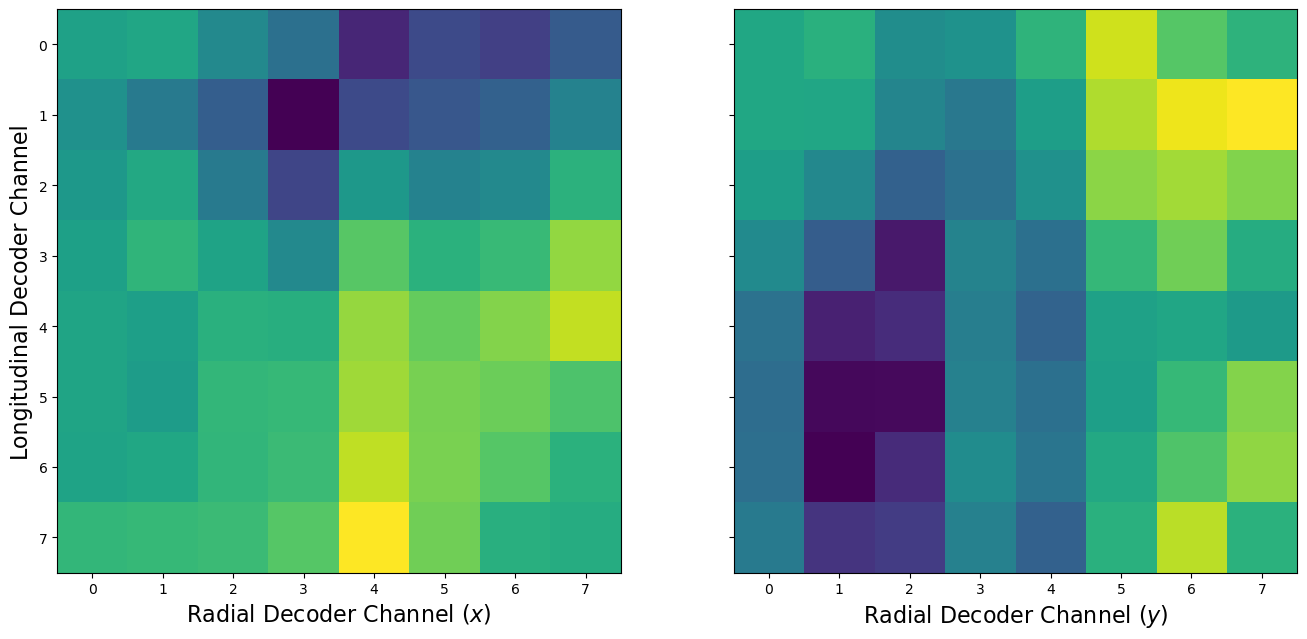

In [53]:
decoder = s.decoder
decoder_heatmap_fig, axes = plt.subplots(1,2,figsize=[16,8],sharex=True, sharey=True)
axes[0].imshow(decoder[-2,:].reshape(8,8))
axes[0].set_xlabel("Radial Decoder Channel ($x$)", fontsize=16)
axes[0].set_ylabel("Longitudinal Decoder Channel", fontsize=16)
axes[1].imshow(decoder[-1,:].reshape(8,8))
axes[1].set_xlabel("Radial Decoder Channel ($y$)", fontsize=16)

## plot decoder directions in task space

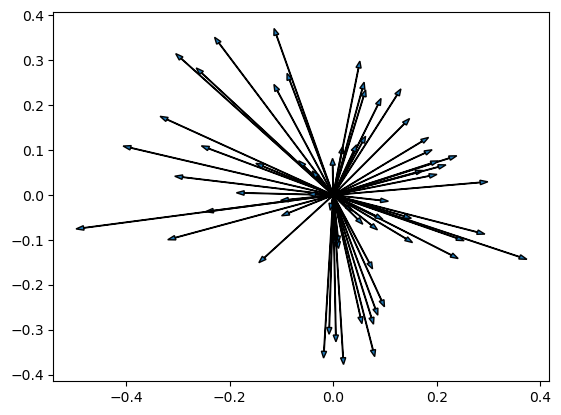

In [54]:
# plot x and y components of the decoder
# this visualizes correlations in task space
for col in decoder[-2:,:].T:
    plt.arrow(0,0,col[0],col[1],head_width=.01)

In [55]:
# decoder_heatmap_fig.savefig("/Users/spencer/motor-control/thesis/images/data_analysis2023/decoder_heatmap.pdf", dpi=300, format="pdf")

## reconstruct EMG filtering

Waiting on Goncalo to respond with images of the workflow

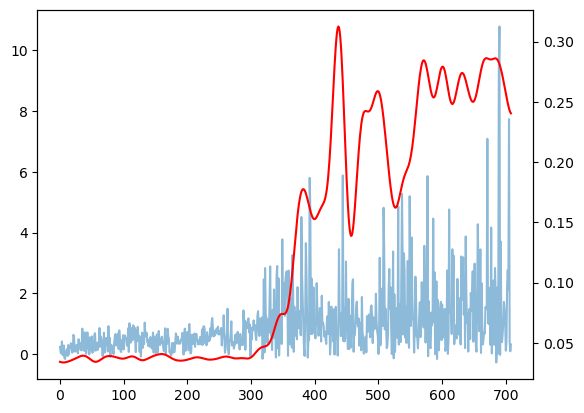

In [56]:
channel = 63

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# get EMG signal from a trial
t = s.tasks["center_hold"].sorted_sessions()[0].sorted_trials()[0]
raw_signal = t.get_raw_emg()[:,:64]
# plt.plot(raw_signal[:,channel])
# ax1.plot(raw_signal[:, channel])

recorded_filtered_signal = t.get_filtered_emg()

# what happens to this signal before it gets decoded?
# looking at the bonsai workflow, we:
# - convert the scale from 0 to 1 -- not sure what this does -- oh, this does nothing, might be a type conversion?
# - highpass with length 250 and cutoff 0.1Hz
highpassed_signal = emg.highpass(raw_signal.T,cutoff=0.1).T
# plt.plot(highpassed_signal[:,channel])

# - divide by the variance.bin file to "standardize"
variance = s.variance
standardized_signal = (variance @ highpassed_signal.T).T
# plt.plot(standardized_signal[:,channel])

# - rectify with abs()
rectified_signal = np.abs(standardized_signal)

# - lowpass with length 500 (or 750? not sure, there are two nodes listed) and cutoff 5Hz
lowpass_signal = emg.lowpass(rectified_signal.T, cutoff=5).T

# - take a moving average with window length (I'm assuming!) 10, as the signal has 10x less samples
# subsample by 10
averaged_signal = emg.moving_average(lowpass_signal[::10,:], window_length=100)
# ax1.plot(averaged_signal[:,channel], alpha=0.5)

second_lowpass_signal = emg.lowpass(averaged_signal.T, cutoff=5).T
ax1.plot(second_lowpass_signal[:,channel], alpha=0.5)

# # - add the offsets.bin file?
# offsets = s.offsets
# offset_signal = np.subtract(standardized_signal, offsets)
# ax1.plot(offset_signal[:,channel])

ax2.plot(recorded_filtered_signal[:, channel], c='r')


# pass it through the decoder
decoded_signal = (decoder @ raw_signal.T[:64,:]).T

filtered_signal = t.get_filtered_emg()
trajectory = t.get_trajectory()

# compare to the behaviorial trajectory from that trial
# determine any weirdness (filtering, etc.) and make note of this

## decode filtered EMG

In [ ]:
class Linear_Control():
    ## DYNAMICS ##
    # px, py, vx, vx, f_left, f_right, fy/f_up
    #
    # | e  0  t  0  0  0  0 | | px |
    # | 0  e  0  t  0  0  0 | | py |
    # | 0  0  e  0 -t  t  0 | | vx |
    # | 0  0  0  e  0  0  t | | vy |
    # | 0  0  0  0  e  0  0 | | fl |
    # | 0  0  0  0  0  e  0 | | fr |
    # | 0  0  0  0  0  0  e | | fy |
    #

    def __init__(self, state_dim=7):
        self.state_dim = state_dim
        self.cursor_state = np.zeros(shape=(self.state_dim, 1))
        # dynamics -- position, velocity, force all decay
        self.decay = 50  # very slow ~ 0.95
        self.dt = 0.1  # game time 100ms steps
        self.A = np.eye(self.state_dim) * np.exp(-1/self.decay)
        # velocities add to positions
        self.A[0, 2] = self.dt
        self.A[1, 3] = self.dt
        # forces add to velocity
        self.A[2, 4] = -self.dt
        self.A[2, 5] = self.dt
        self.A[3, 6] = self.dt

        # control mapping
        self.B = np.zeros((self.state_dim, NUM_ELECTRODES))
        # input acts only on the force rows
        self.B[-3, -3] = 1  # replace with mapping!
        self.B[-2, -2] = 1
        self.B[-1, -1] = 1

        # observation -- only feed back position
        self.observation = np.zeros((2, 1))
        self.H = np.zeros((2, self.state_dim))
        self.H[0, 0] = 1  # px
        self.H[1, 1] = 1  # py

    def advance_dynamics(self, control, scaling=1):
        control *= scaling
        self.cursor_state = self.A.dot(self.cursor_state) + self.B.dot(control)

    def advance_observation(self):
        self.observation = self.H.dot(self.cursor_state)

## plot outcomes vs. decoder correlation

0.05304496691303853


Text(0.5, 30, '$R^2$ = 0.053')

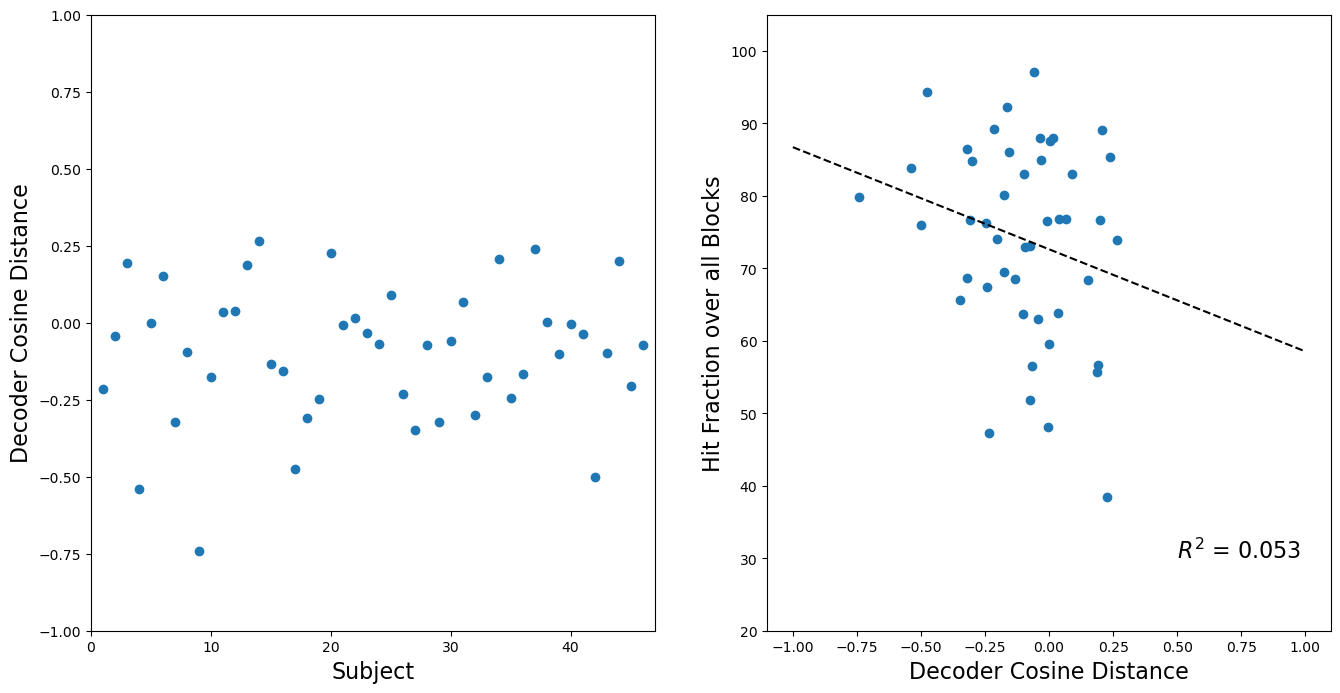

In [94]:
decoder_fig, (cos_ax, ax) = plt.subplots(1,2,figsize=(16,8))

# [-1,1] 1 is parallel, -1 is antiparallel, 0 is orthogonal
cos_ax.plot(range(1,len(cosines)+1), cosines,"o")
cos_ax.set_ylim([-1,1])
cos_ax.set_xlim([0,len(cosines)+1])
cos_ax.set_ylabel("Decoder Cosine Distance", fontsize=16)
cos_ax.set_xlabel("Subject", fontsize=16)

ax.plot(cosines, total_fractions ,"o")
from scipy.stats import linregress
result = linregress(cosines, total_fractions)
x = np.linspace(-1,1,100)
ax.plot(x, result.intercept + result.slope*x,"k--")
print(result.rvalue**2)
ax.set_ylim([20,105])
ax.set_xlim([-1.1,1.1])
ax.set_ylabel("Hit Fraction over all Blocks", fontsize=16)
ax.set_xlabel("Decoder Cosine Distance", fontsize=16)
ax.annotate(f"$R^2$ = {np.round(result.rvalue**2, 3)}", (0.5,30), fontsize=16)

In [95]:
decoder_fig.savefig("/Users/spencer/motor-control/thesis/images/data_analysis2023/decoder_correlation.pdf", dpi=300, format="pdf")